In [1]:
import os
from collections import OrderedDict

import torch
import torch.optim

from latent_rationale.sst.vocabulary import Vocabulary
from latent_rationale.sst.models.model_helpers import build_model
from latent_rationale.sst.util import get_predict_args, sst_reader, \
    load_glove, print_parameters, get_device, find_ckpt_in_directory, \
    plot_dataset
from latent_rationale.sst.evaluate import evaluate, predict


from latent_rationale.sst.util import Example
from IPython.display import Image
import os

Where code and models live

In [2]:
cd /home/wferrei1/github/probabll/interpretable_predictions

/home/wferrei1/github/probabll/interpretable_predictions


In [3]:
def config(ckpt, verbose=False):
    """
    Loads a trained model stored in a directory `ckpt`.
    Returns
        - cfg: dict of options
        - ckpt: trained model
        - device: 
        - model:
    """
    device = get_device()
    ckpt_path = find_ckpt_in_directory(ckpt)
    ckpt = torch.load(ckpt_path, map_location=device)
    cfg = ckpt["cfg"]
    if verbose:
        for k, v in cfg.items():
            print("{:20} : {:10}".format(k, v)) 
                    
    batch_size = cfg.get("eval_batch_size", 25)

    vocab = Vocabulary()
    vectors = load_glove(cfg["word_vectors"], vocab)  # this populates vocab

    # Map the sentiment labels 0-4 to a more readable form (and the opposite)
    i2t = ["very negative", "negative", "neutral", "positive", "very positive"]
    t2i = OrderedDict({p: i for p, i in zip(i2t, range(len(i2t)))})

    # Build model
    model = build_model(cfg["model"], vocab, t2i, cfg)

    # load parameters from checkpoint into model
    model.load_state_dict(ckpt["state_dict"])
    model.to(device)
        
    return cfg, ckpt, device, model

def validate(cfg, model, device):
    dev_data = list(sst_reader("data/sst/dev.txt"))
    dev_eval = evaluate(model, dev_data, batch_size=cfg.get("eval_batch_size", 25), device=device)
    print("dev acc", dev_eval["acc"])

In [4]:
trained_models = [
    'pretrained/beer_latent_30pct', 
    'pretrained/beer_latent_50pct', 
    'pretrained/beer_latent_50pct_coh_002'
]
cfg, ckpt, device, model = config(trained_models[1])  

Classifier #params: 543905
IndependentLatentModel #params: 543002


In [5]:
validate(cfg, model, device)

dev acc 0.45685740236107464


# Explainable Text Classifiers


The major goal of science is to develop and improve existing **explanations**. Some claim you only **understand** something if you can explain it. 

In **natural sciences**, we look to understand certain aspects of reality. When we achieve that understanding we pack explanations up into what we call a **theory**. 

Theories are essentially as good as their explanatory power. A very practical use of a theory is to make **predictions** about the real world, where we try to make informed guesses at how certain aspects of the world will respond to certain stimuli.

In **computer science** we are also interested in theories, but in **natural language processing** (NLP) sometimes we make do with predictions alone. Predictions without a theory have no explanatory power, they simply tell us what to expect, but without knowing why that might be the case we are deprived of the choice of **criticising** the prediction. 

It's like when a person makes a claim without defending it. There's no space for debate! Some might say that there's no use to claims without arguments. 

Perhaps in some contrived artificial settings one can find use to predictions without explanations. For example, leaderboards and other forms of gamification of research.

But in the real world predictions are only as good as the theories on which they are based. Theories which in turn are only as good as the explanations they provide. 

In NLP we are often interested in categorising excerpts of text with respect to certain concepts or abstractions of practical relevance. For example, we may want to make informed guesses at one's sentiment towards a film based on a written review.

Our best technology, as far as prediction is concerned, is called **neural networks** (NNs). 
NNs are powerful blackbox predictors, above all, they are trainable predictors. In a strong sense, NNs abstract away from explanations, though an optimist might say NNs learn to explain observations in their own way.

Much like in the natural sciences where one can observe the real world, in NLP we can observe examples of language being actively used to convey opinions. We have also developed ways to categorise one's opinions, for example, using star ratings.

NNs learn by postulating a mapping from inputs (aka predictors) to outputs (aka responses). This mapping is nothing but a mathematical object full of adjustable parameters, we call this object a *parametric function*. By exploiting mathematical properties of said function, mostly a notion of regularity known as *smoothness*, we can automatically adjust the parameters based on a measure of misfit of the model to the observations.

It is however possible to bring NNs closer to theories. Every theory is data-driven, that is, scientists postulate theories by analysing data and criticising previous theories. Here we will have NNs postulate theories which they will express in a technical language we understand very well, that of statistical modelling.

We will tell NNs that they can learn how to perform predictions by mimicing observations in a dataset, but we will tell them that they should assume that predictions come about in a specific way:

1. First we read some text (this is our *stimuli*)
2. Then we judge which parts of the text are sufficient to support a certain opinion, think of this as a rationale for the opinion (this is will assists us in making up our own *explanation*).
3. Then we learn some blackbox function that maps the rationale to an opinion in the form of a star rating (this is our *prediction*). 
4. We also promote use of compact rationales motivated by our own knwoledge and intuitions about how language works.

Certainly no aspect of this process is dictated by a powerful theory of how opinions are formed and verbally expressed in reality, but unlike a typical blackbox NN, there's a degree of transparency in its inner workings, it postulates a particular story of how data come about, and this story is something we can use. In particular we like to think of it as evidence to support an explanation.

**Remark** 

Our classifier does not explain its decision: it cannot do that, it does not master the English language, it lacks world knowledge, it is not an *artifical intelligence*, it automates and discovery of patterns in language use and it exploits those to make decisions. It does, however, expose what subset of the predictors the NN judged necessary and sufficient for its guess, and we can use this information as the basis for an explanation.


# Helpers

In [16]:
def demo(sentence, label=None, labels=None, writeto='tmp', sentiments={0: 'very negative', 1: 'negative', 2: 'neutral', 3: 'positive', 4: 'very positive', None: '?'}):
    if type(sentence) is str:
        sentence = sentence.split()
    instance = Example(
        sentence, 
        0 if label is None else label, 
        [0] * len(sentence) if labels is None else labels
    )
    data = [instance]
    _, preds = predict(model, data, batch_size=1, device=device)
    print("Target '%s' Prediction '%s'" % (sentiments[label], sentiments[preds[0]]))
    if writeto:
        os.makedirs(writeto, exist_ok=True)    
        plot_dataset(model, data, batch_size=1, device=device, save_path=writeto, ext='png')
        return Image(filename='%s/plot0000.z.png' % writeto)

In [17]:
dev_data = list(sst_reader("data/sst/dev.txt"))

Dazzles with its fully-written characters , its determined stylishness -LRB- which always relates to characters and story -RRB- and Johnny Dankworth 's best soundtrack in years .
Target 'very positive' Prediction 'very positive'


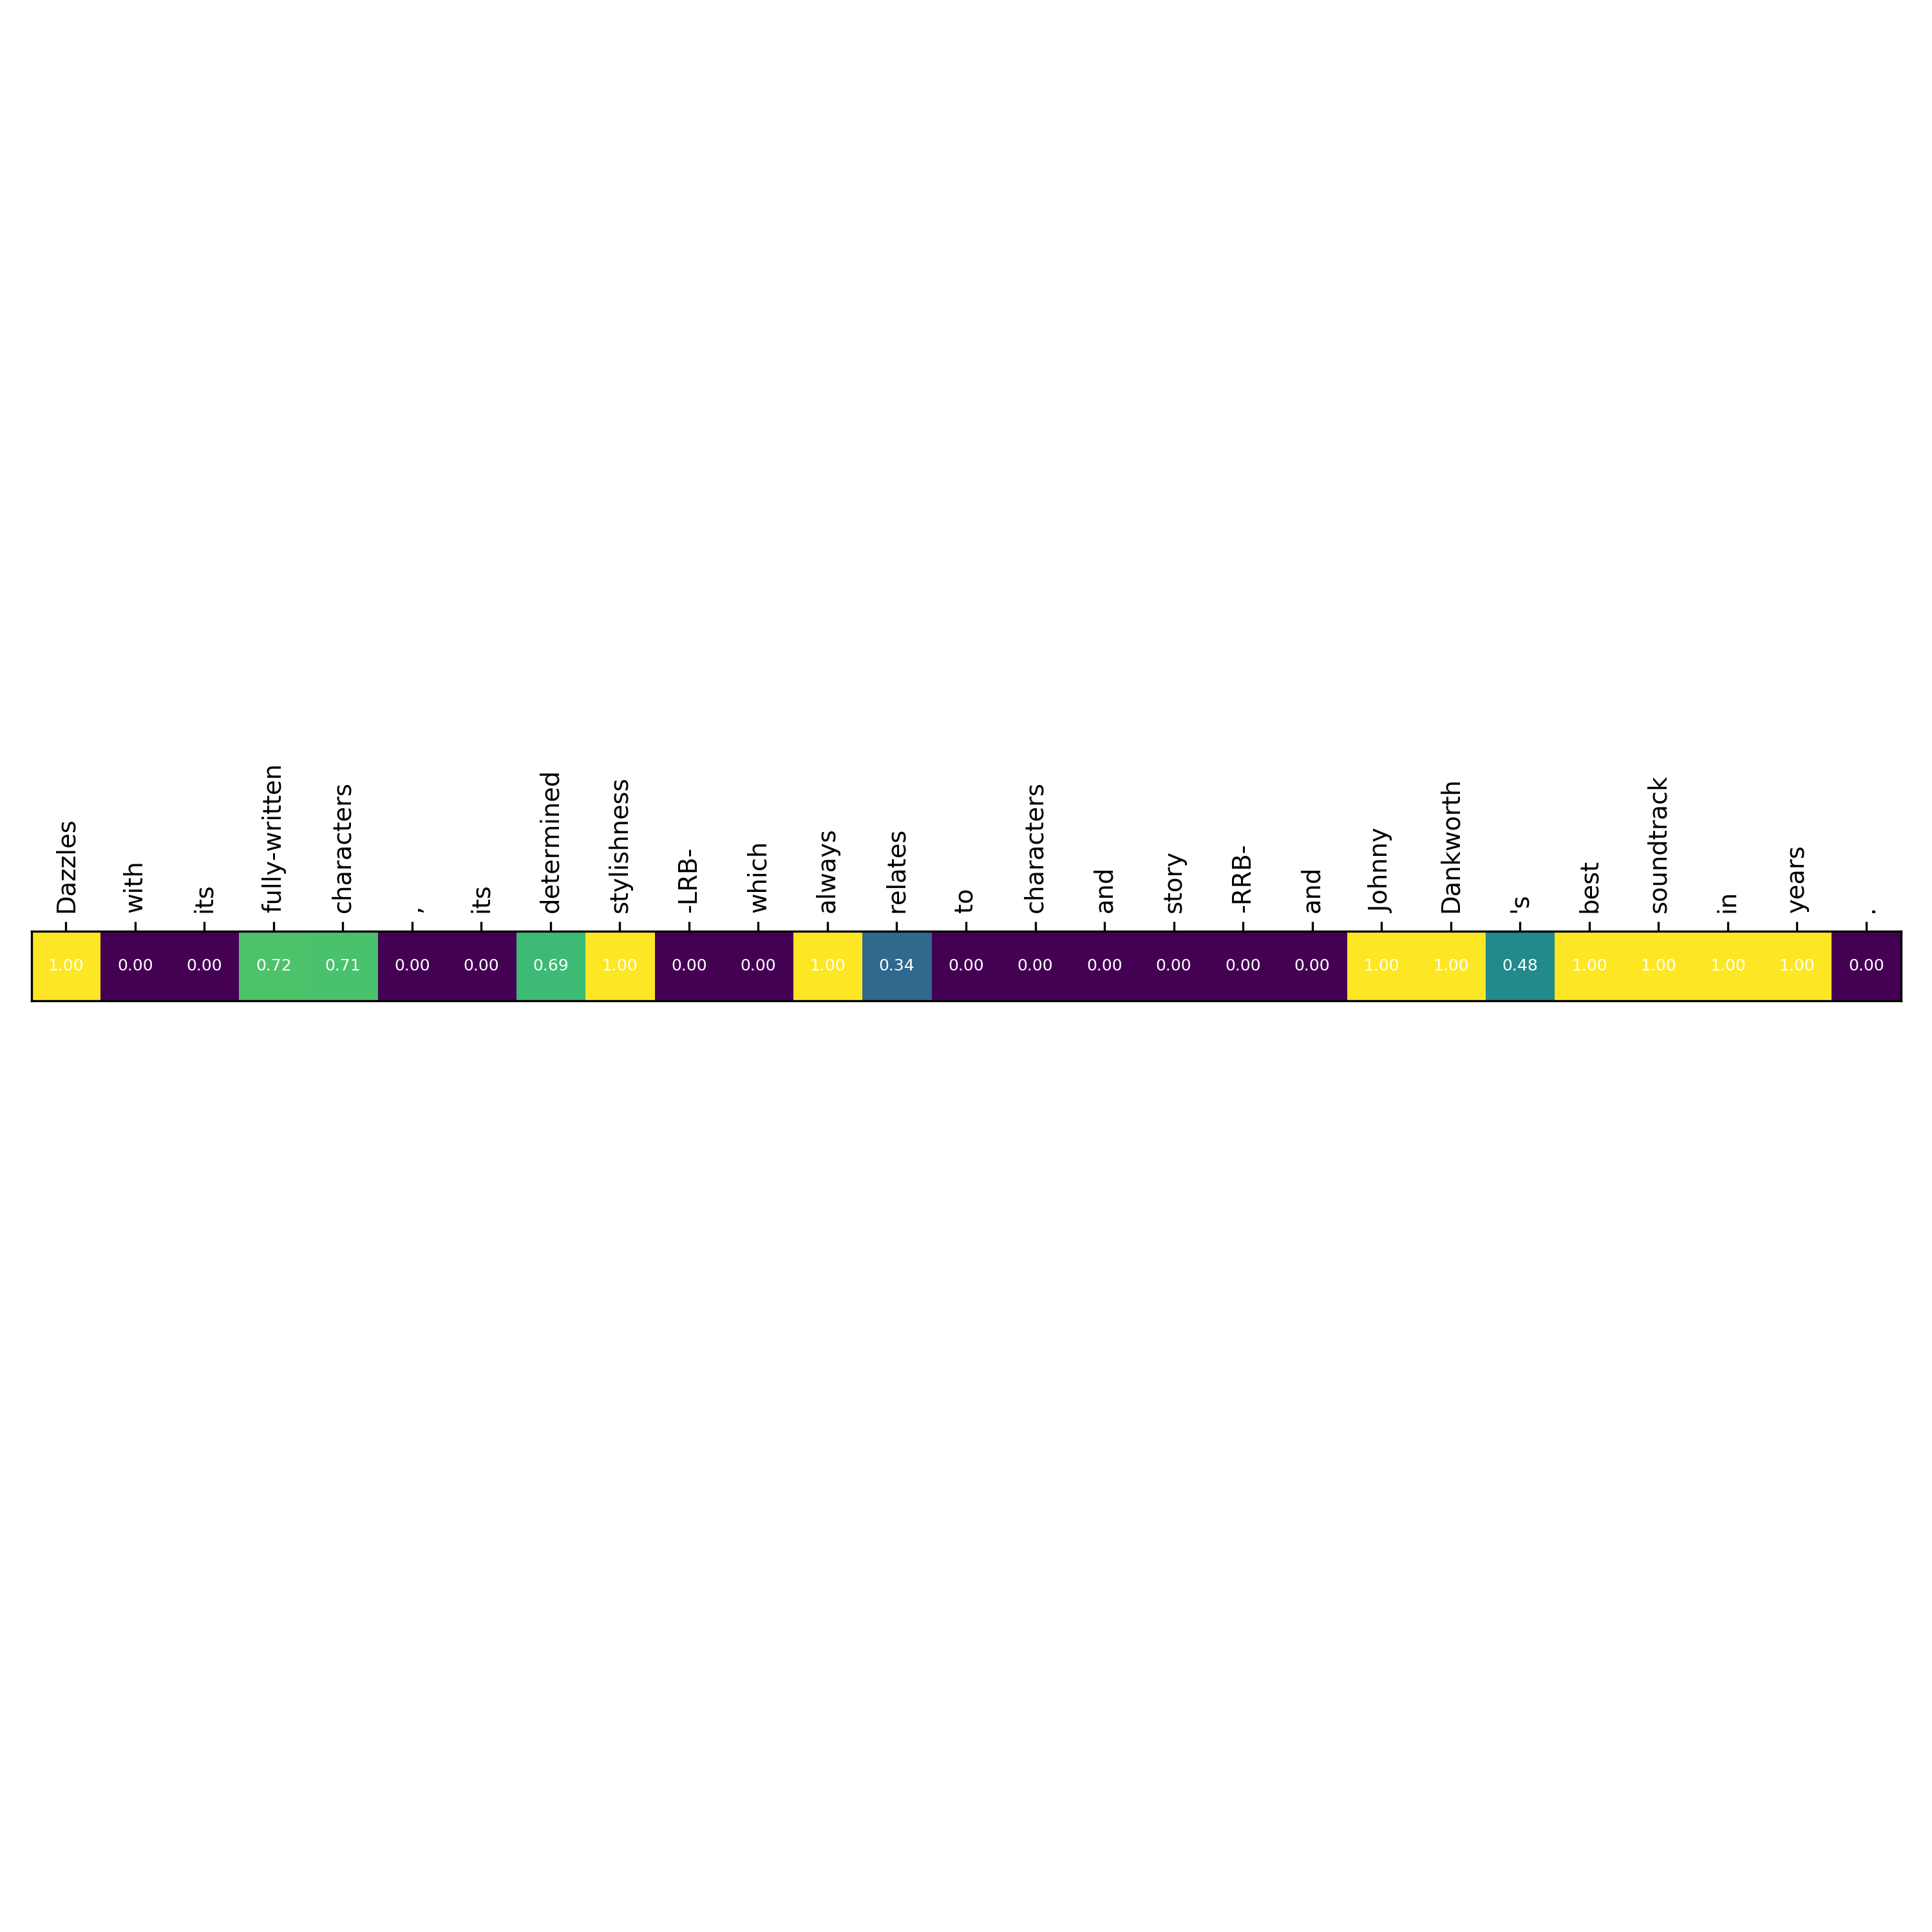

In [18]:
print(' '.join(dev_data[7].tokens))
demo(dev_data[7].tokens, dev_data[7].label, writeto='demo/0-7')

# Demo

Type a sentence and see how it is classified. Try and make up an explanation using the predicted rationales.

Target '?' Prediction 'negative'


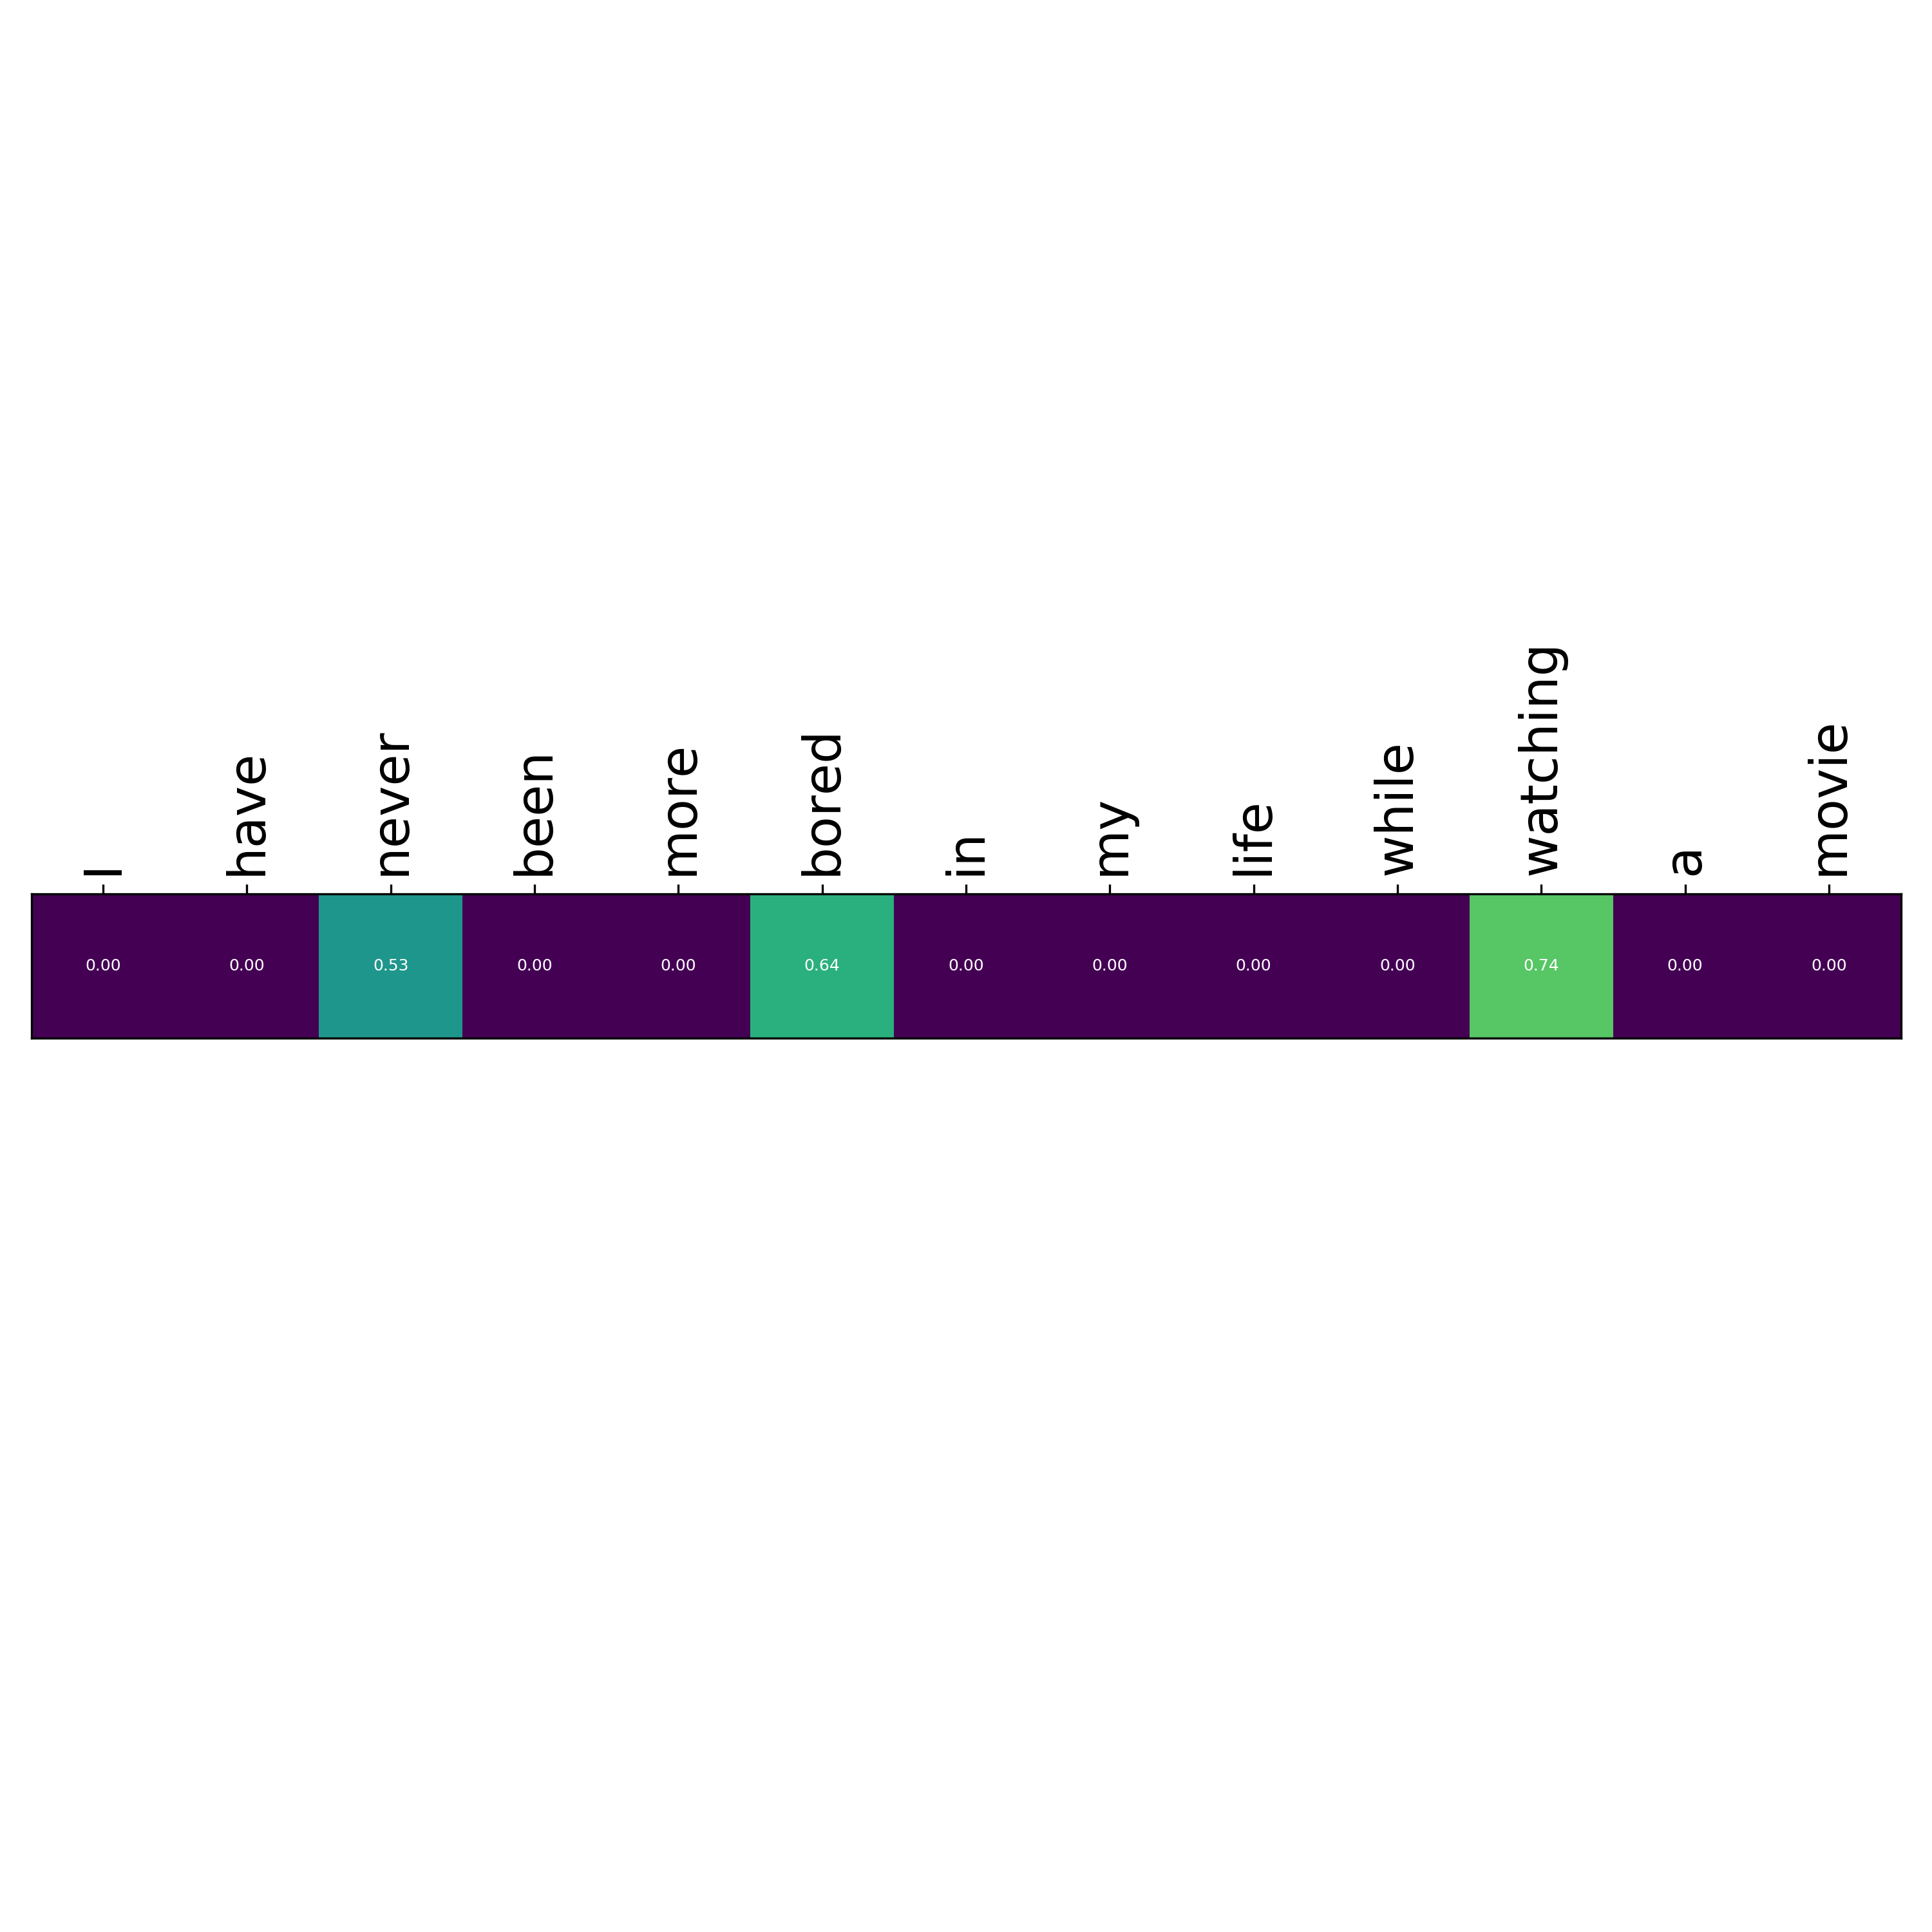

In [19]:
demo("I have never been more bored in my life while watching a movie", writeto='demo/1')

Target '?' Prediction 'neutral'


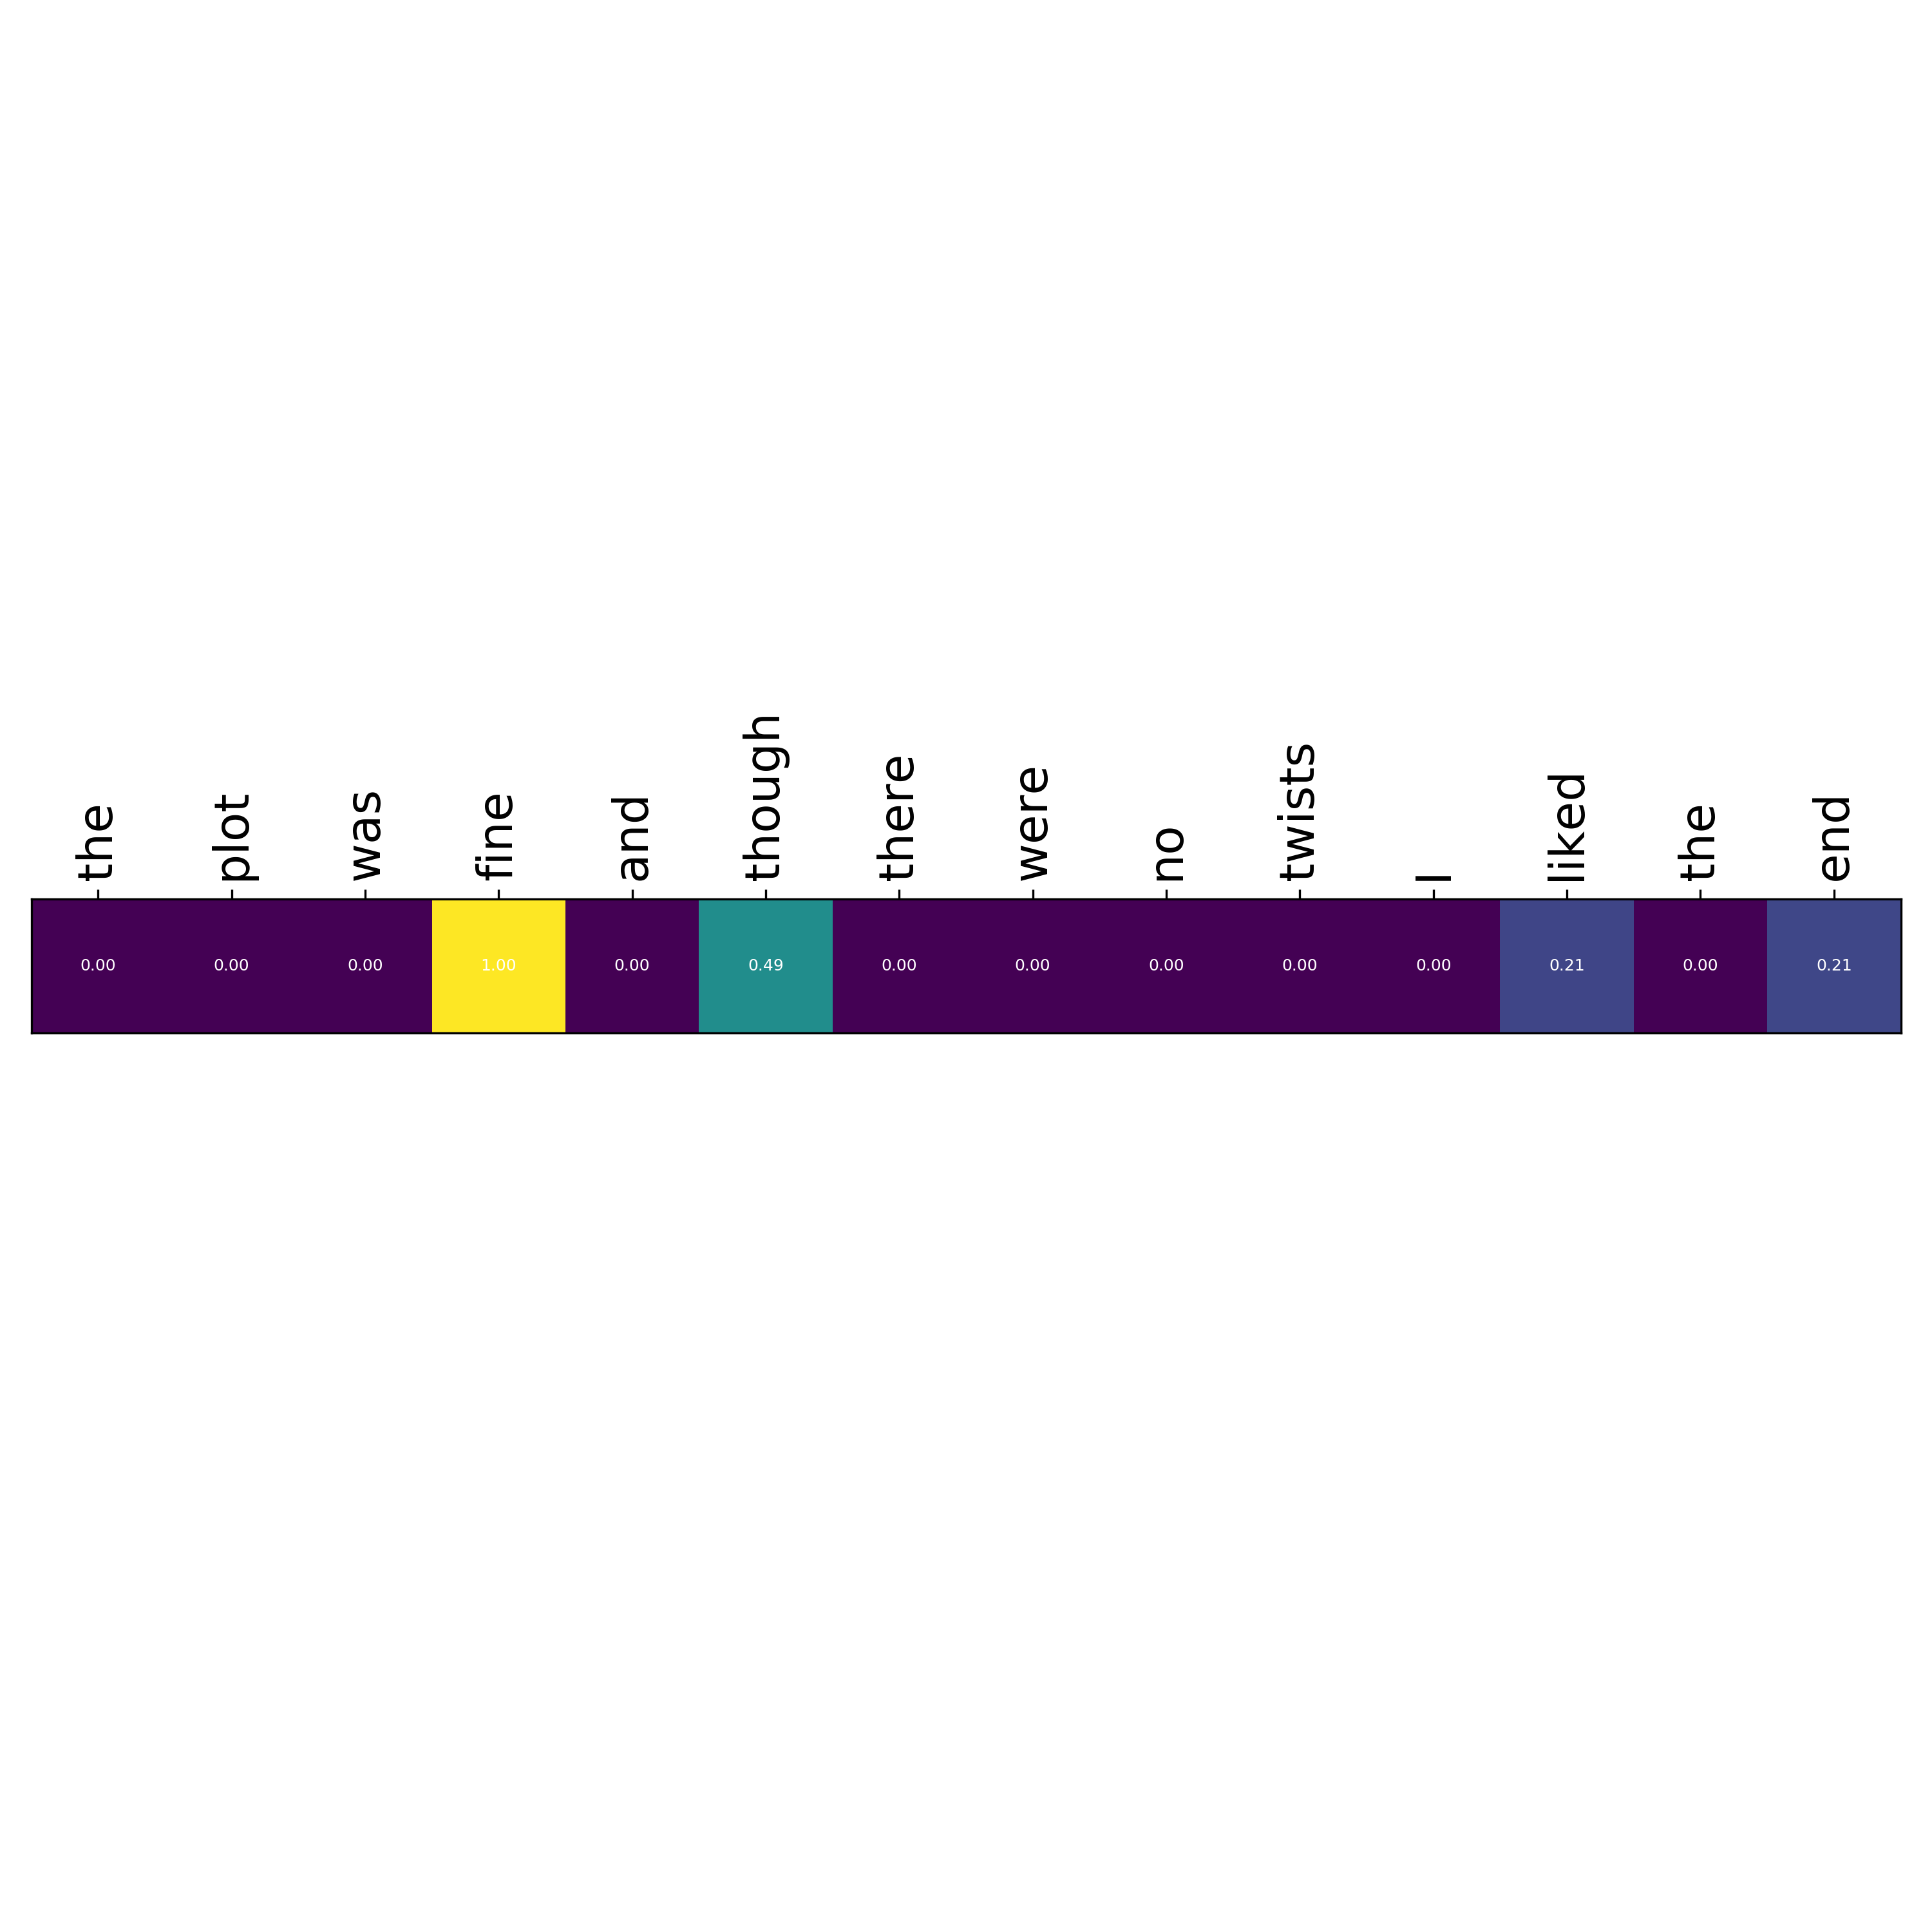

In [20]:
demo("the plot was fine and though there were no twists I liked the end", writeto='demo/2')

Target '?' Prediction 'positive'


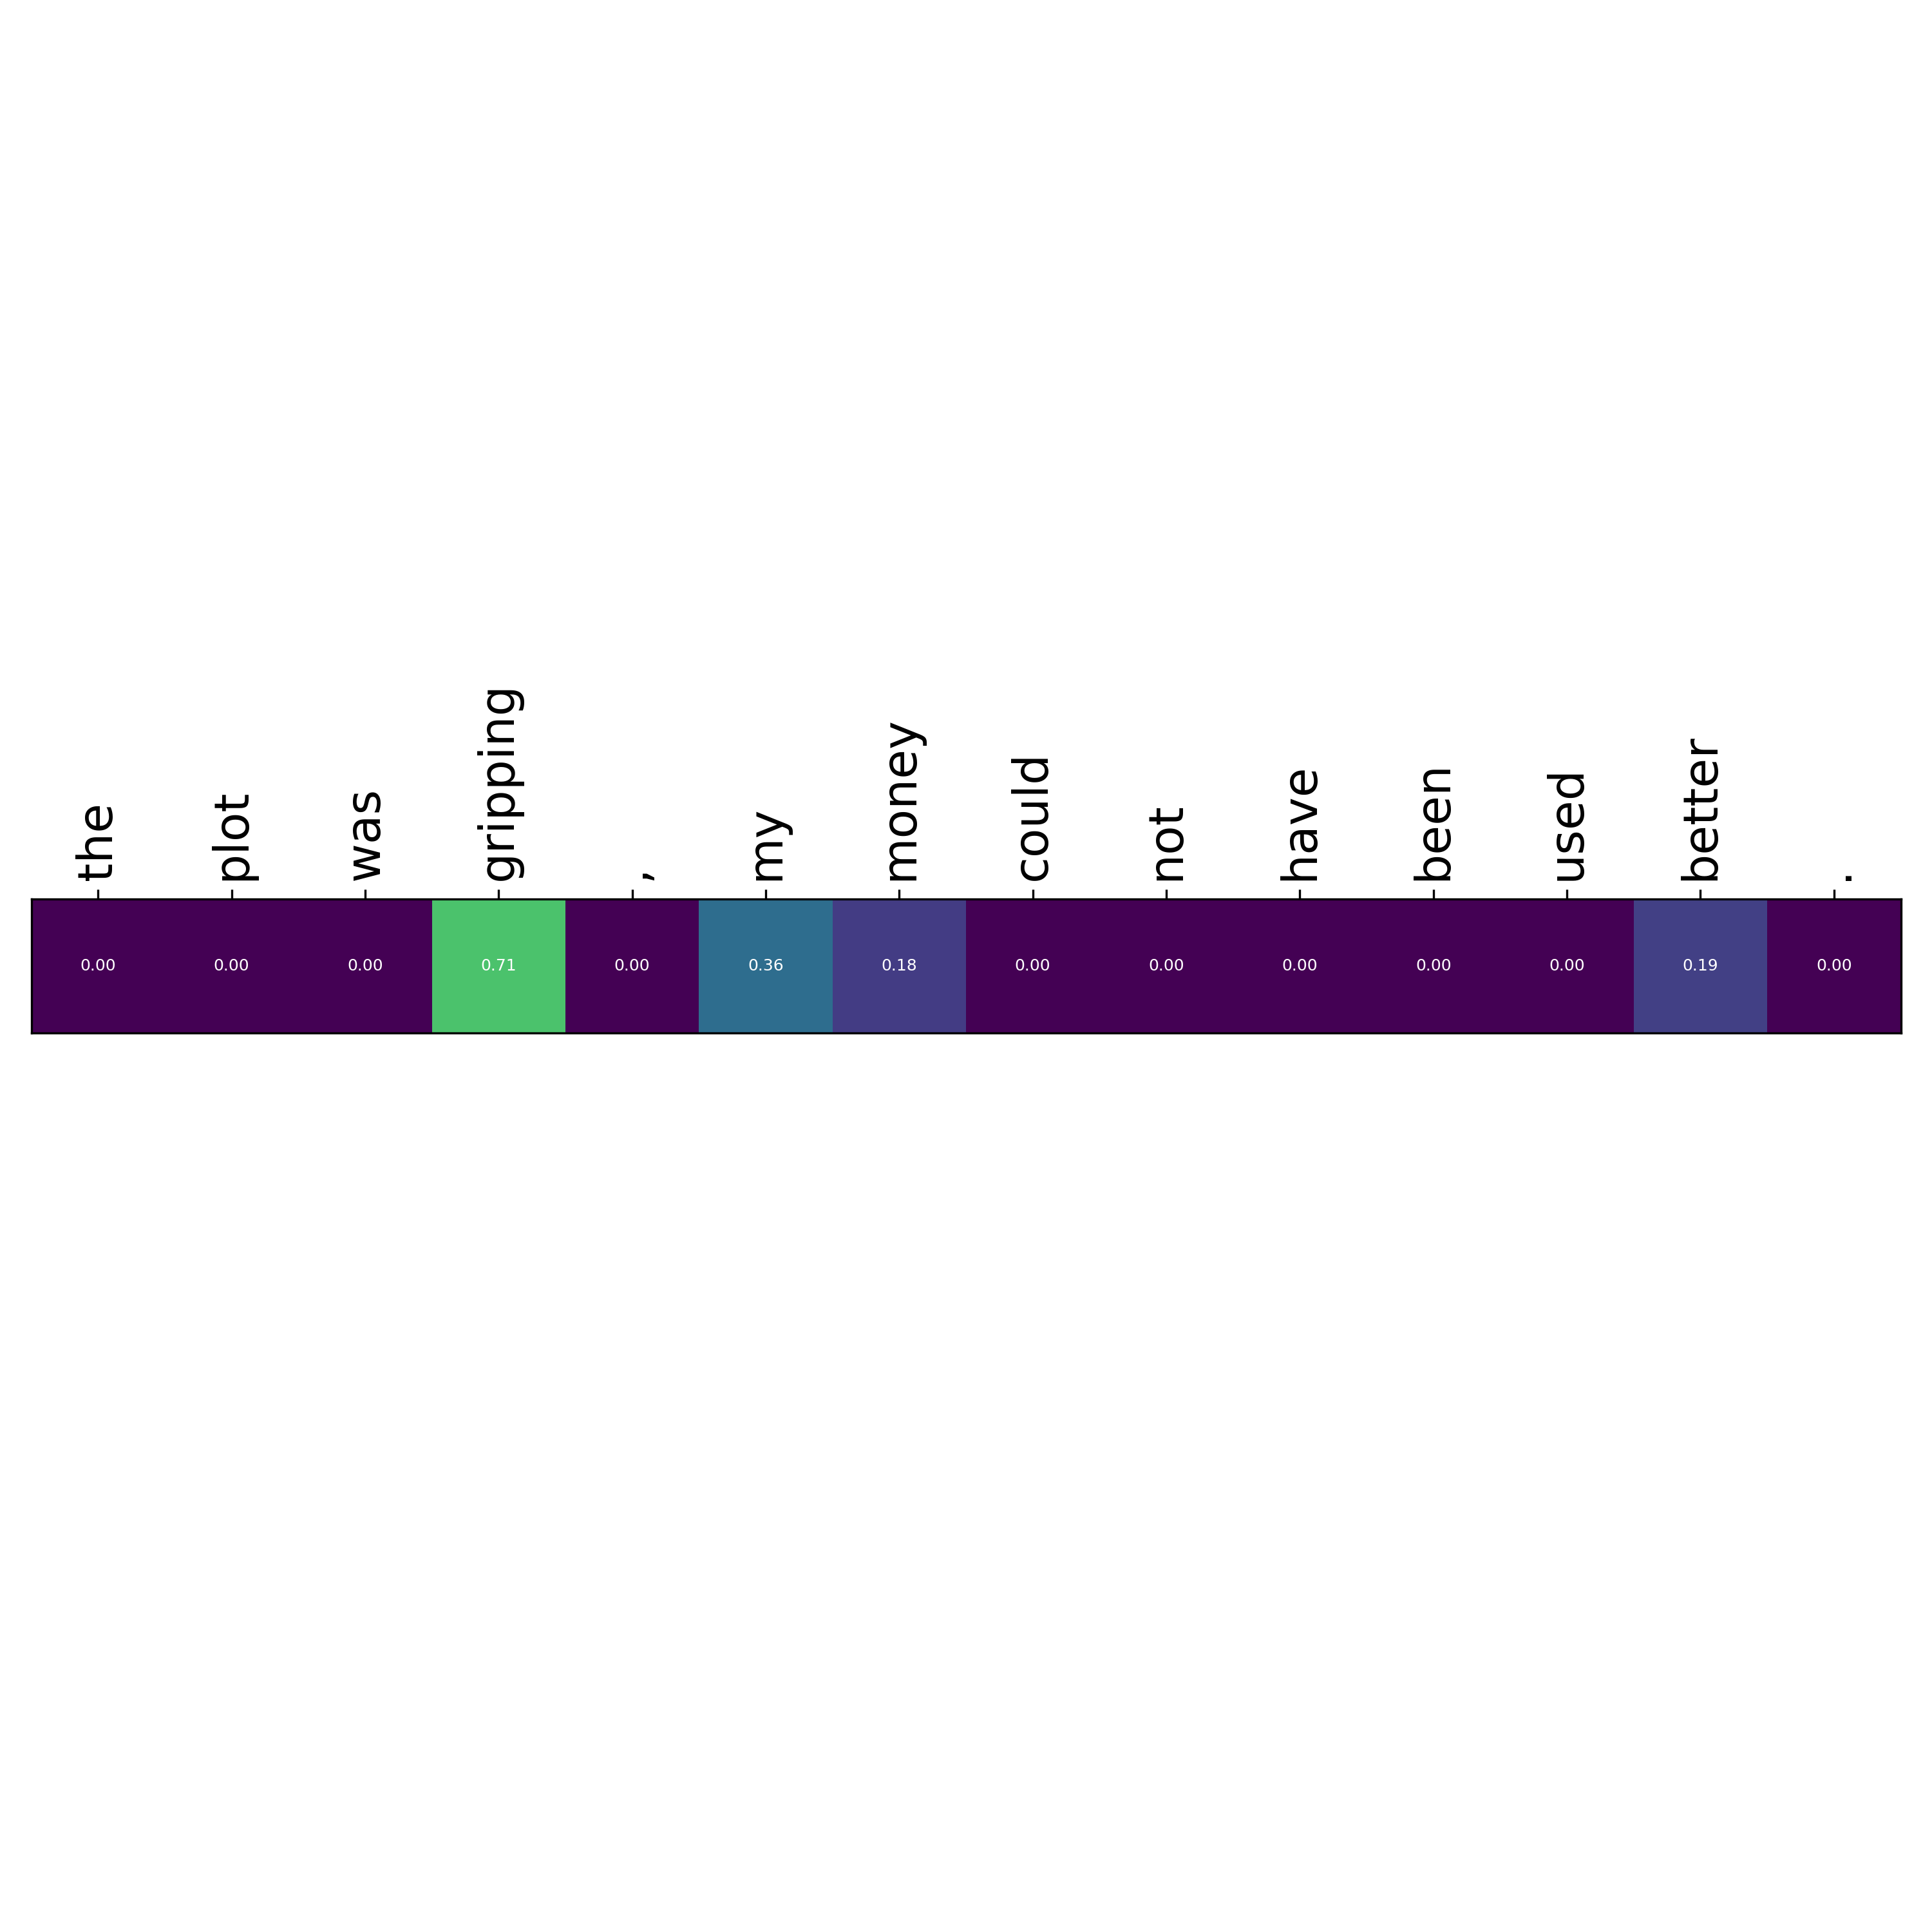

In [22]:
demo("the plot was gripping , my money could not have been used better .", writeto='demo/2')